In [1]:
import os
import sys
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from scipy.linalg import pinv
import scipy
import pydmd

from tqdm import tqdm

from sklearn.decomposition import PCA

import time

import seaborn as sns
import pickle as pkl

import sys
sys.path.append('../')
from utils import *

import scipy

this is a rough sanity check to verify that $\bar{B}$ produces similar forcing contribution results to $F$. Specifically, it does not capture the forcing contribution...

In [2]:
def TDE_wravel(X: np.array, lag: int):
    T, N = X.shape
    X_delay = np.zeros((T-lag+1, N*lag), dtype = 'complex128')
    for l in range(lag):
        X_delay[:,l*N:(l+1)*N] = X[l:T-(lag-1)+l]
    
    return X_delay

def TDE_unwravel(X_delay: np.array, lag: int):
    T_all, N_all = X_delay.shape

    N = N_all // lag
    T = T_all+lag-1
    X = np.zeros((T, N),dtype = 'complex128')
    for t in range(T_all):
        for l in range(lag):
            X[t+l,:] = X_delay[t,l*N:(l+1)*N]
        
    return X

In [3]:
lag = 30
scenario = 370 #focus on high aerosol scenario

xr_train_clim = xr.open_dataset('../data/train_val/outputs_historical.nc').mean(dim='member')
xr_test_clim = xr.open_dataset(f'../data/train_val/outputs_ssp{scenario}.nc').mean(dim='member')

tas_all = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').tas.values
times = xr.concat([xr_train_clim, xr_test_clim], dim = 'time').time
ntime, nlat, nlong = tas_all.shape
tas_data = tas_all.reshape(ntime, -1)[lag-1:,:]

forcing_data = np.load(f'../data/forcings/historical+ssp{scenario}_forcing.npy').T

control_data = TDE_wravel(forcing_data, lag = lag)

In [4]:
# collect data
X = tas_data[:-1,:].T
Xp = tas_data[1:,:].T
Y = control_data[:-1,:].T


In [5]:
#svd for POD modes
Uhat, Shat, VhatT = scipy.linalg.svd(Xp, full_matrices=False) 

#svd for regression
Omega = np.vstack([X,Y])
U, S, V = scipy.linalg.svd(Omega, full_matrices=False)
Ub = U[13824:,:] # only look at the B part

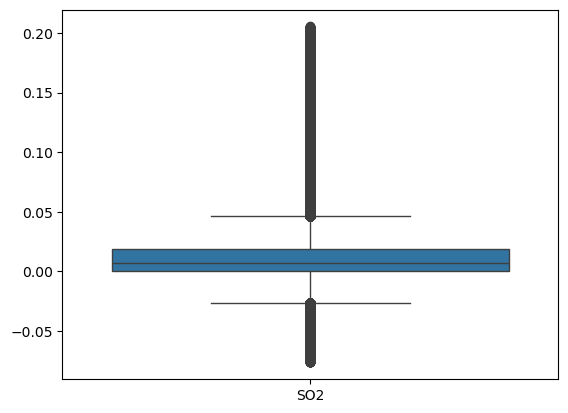

In [6]:
#SO2 with first 5 POD modes

B = Uhat[:,:5] @ Uhat[:,:5].conj().T @ Xp @ V.conj().T @ np.diag(S**(-1)) @Ub.conj().T

ssp = scenario 
forcing_data = np.load(f'../data/forcings/historical+ssp{ssp}_forcing.npy').T
control_data = TDE_wravel(forcing_data, lag = lag)

data = {}
i=2
agent = 'SO2'
hankel_idx = np.arange(i,lag*4,4)[::-1]

zs = B[:, hankel_idx] @ control_data[:,hankel_idx].T

data[agent] = np.real(zs.flatten())


axi = sns.boxplot(data=data)

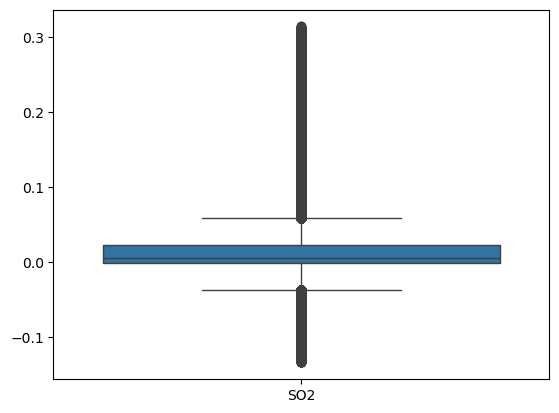

In [7]:
#SO2 with all of Bbar

Bbar = Xp @ V.conj().T @ np.diag(S**(-1)) @Ub.conj().T

ssp = scenario 
forcing_data = np.load(f'../data/forcings/historical+ssp{ssp}_forcing.npy').T
control_data = TDE_wravel(forcing_data, lag = lag)

data = {}
i=2
agent = 'SO2'
hankel_idx = np.arange(i,lag*4,4)[::-1]

zs = Bbar[:, hankel_idx] @ control_data[:,hankel_idx].T

data[agent] = np.real(zs.flatten())


axi = sns.boxplot(data=data)